In [1]:
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet
from branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation with closed-form formula given by Borodin

In [2]:
lower_bound, upper_bound = -2, 2

def conditional_probability_to_survive(t, x, y, k_arr=range(-5, 5)):
    ans = 0
    for k in k_arr:
        ans += (
                torch.exp(((y - x) ** 2 - (y - x + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
                - torch.exp(((y - x) ** 2 - (y + x - 2 * lower_bound + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
        )
    return ans.prod(dim=0)

def is_x_inside(x):
    return torch.logical_and(lower_bound <= x, x <= upper_bound).all(dim=0)

## Example 1: heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
\begin{align*}
u_A(t, x) = 
\sum\limits_{k=-\infty}^\infty
& \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
\\
& - \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
\end{align*}
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [7]:
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi, n = 0., lower_bound, upper_bound, 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

patches = 10
T = patches * 1.0
true = exact_example(t_lo, grid_d_dim, T)
true_with_bound = exact_example(t_lo, grid_d_dim, T, with_bound=True)
terminal = exact_example(T, grid_d_dim, T)

Patch 0: generation of samples take 0.47871899604797363 seconds.


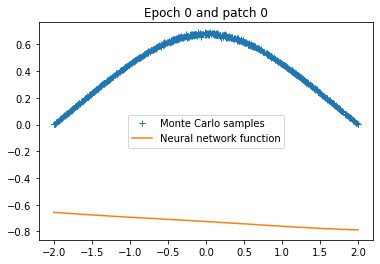

Patch 0: epoch 0 with loss 1.5763740539550781


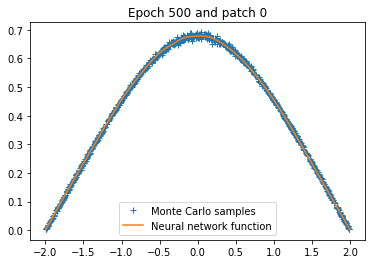

Patch 0: epoch 500 with loss 1.5217096006381325e-05


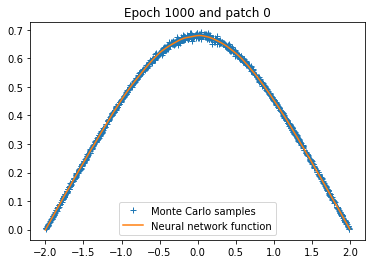

Patch 0: epoch 1000 with loss 1.469581275159726e-05


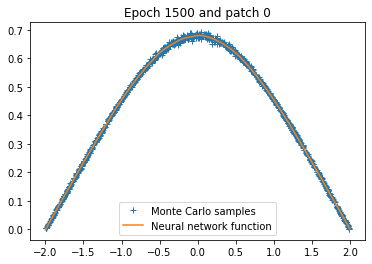

Patch 0: epoch 1500 with loss 1.430162683391245e-05


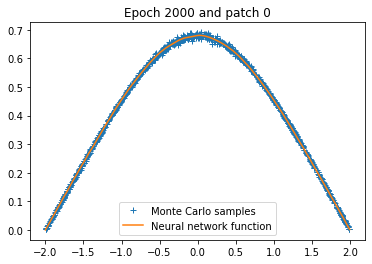

Patch 0: epoch 2000 with loss 1.4574835404346231e-05


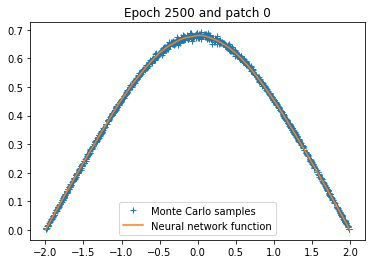

Patch 0: epoch 2500 with loss 1.405858711223118e-05


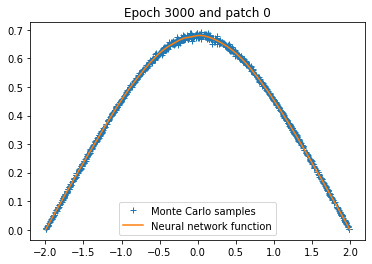

Patch 0: epoch 3000 with loss 1.450162562832702e-05


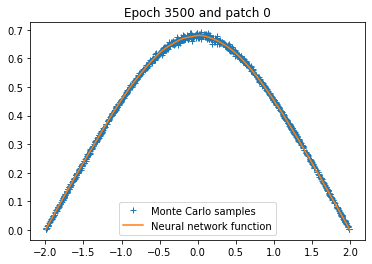

Patch 0: epoch 3500 with loss 1.3941443285148125e-05


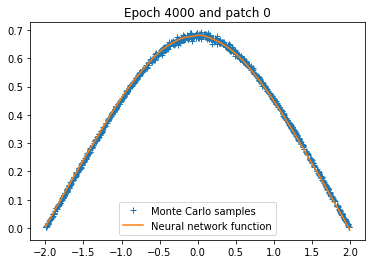

Patch 0: epoch 4000 with loss 1.5793564671184868e-05


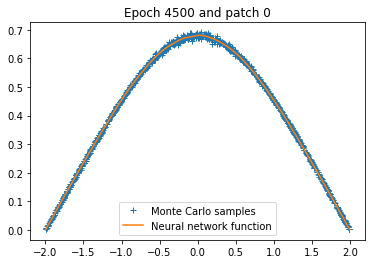

Patch 0: epoch 4500 with loss 1.4472580915025901e-05


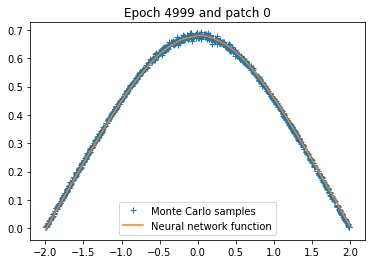

Patch 0: epoch 4999 with loss 2.7699883503373712e-05
Patch 0: training of neural network with 5000 epochs take 20.17610001564026 seconds.
Patch 1: generation of samples take 0.6257991790771484 seconds.


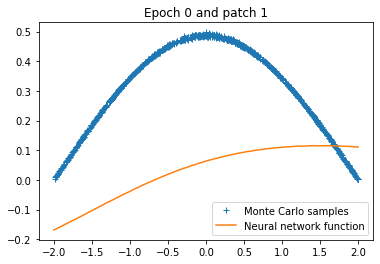

Patch 1: epoch 0 with loss 2.805339813232422


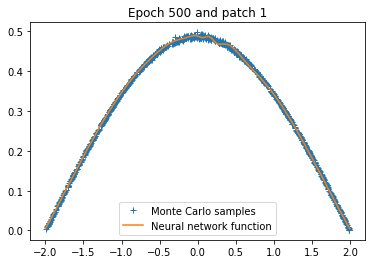

Patch 1: epoch 500 with loss 8.569969395466615e-06


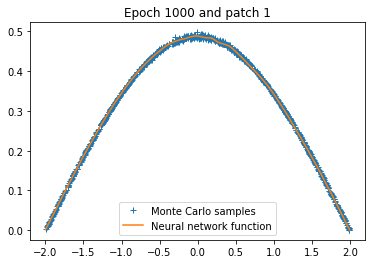

Patch 1: epoch 1000 with loss 4.031930984638166e-06


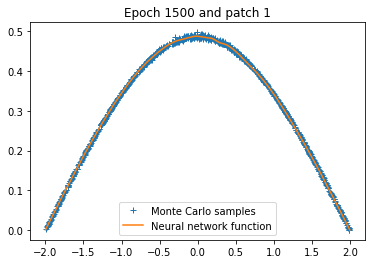

Patch 1: epoch 1500 with loss 3.749522420548601e-06


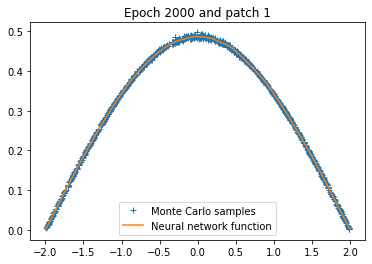

Patch 1: epoch 2000 with loss 3.5723569453693926e-06


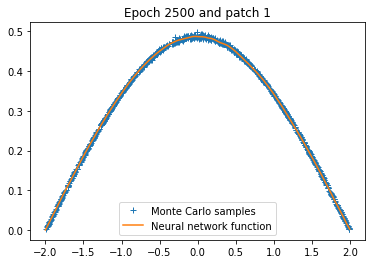

Patch 1: epoch 2500 with loss 3.7448257899086457e-06


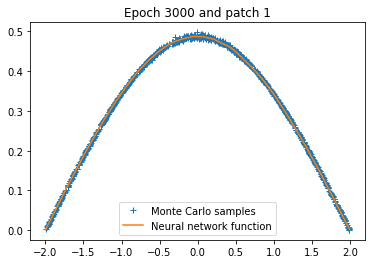

Patch 1: epoch 3000 with loss 3.914713943231618e-06


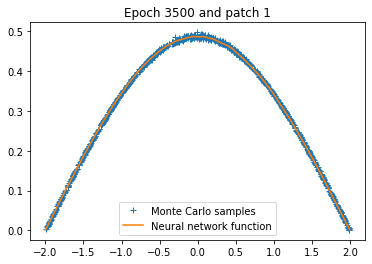

Patch 1: epoch 3500 with loss 3.3746428016456775e-06


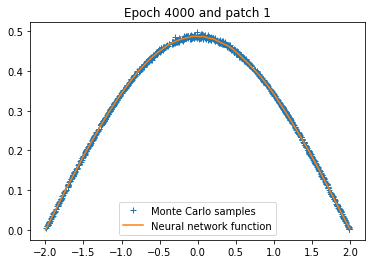

Patch 1: epoch 4000 with loss 4.550270205072593e-06


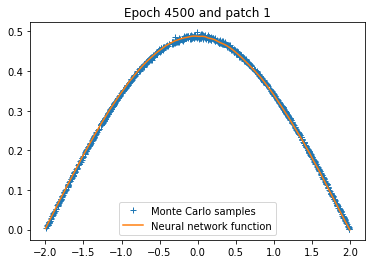

Patch 1: epoch 4500 with loss 3.610810836107703e-06


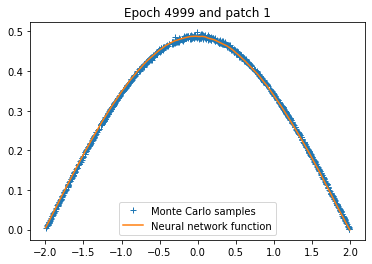

Patch 1: epoch 4999 with loss 1.1672776963678189e-05
Patch 1: training of neural network with 5000 epochs take 20.999719381332397 seconds.
Patch 2: generation of samples take 0.62674880027771 seconds.


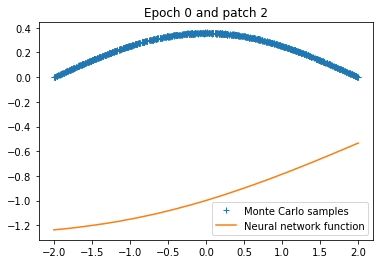

Patch 2: epoch 0 with loss 7.740444183349609


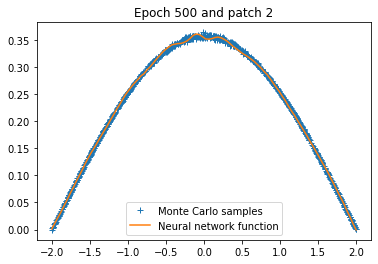

Patch 2: epoch 500 with loss 5.972855433356017e-06


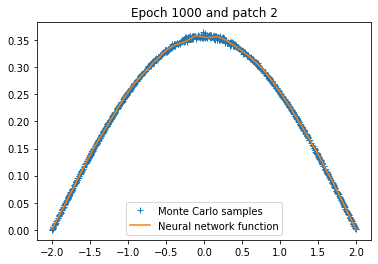

Patch 2: epoch 1000 with loss 1.3464229596138466e-05


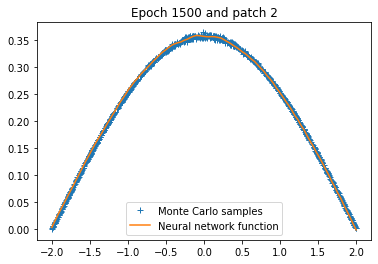

Patch 2: epoch 1500 with loss 3.848710548481904e-06


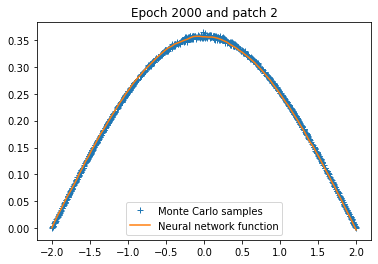

Patch 2: epoch 2000 with loss 1.869023617473431e-05


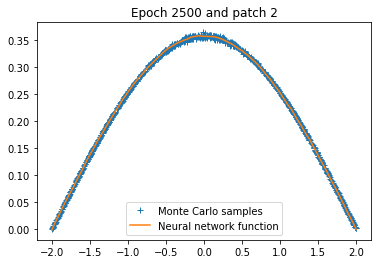

Patch 2: epoch 2500 with loss 2.454423338349443e-06


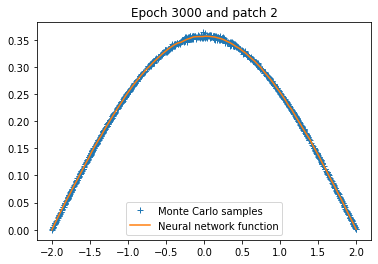

Patch 2: epoch 3000 with loss 2.1751482108811615e-06


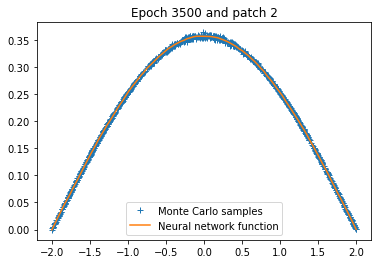

Patch 2: epoch 3500 with loss 4.108301709493389e-06


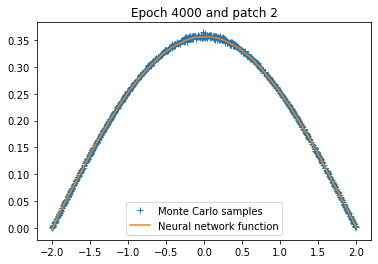

Patch 2: epoch 4000 with loss 2.280037506352528e-06


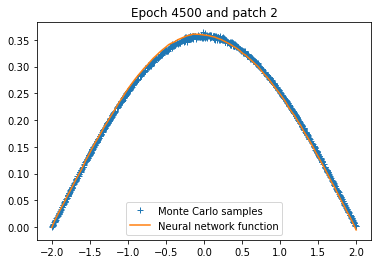

Patch 2: epoch 4500 with loss 1.7582078726263717e-05


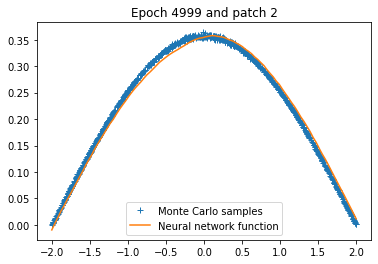

Patch 2: epoch 4999 with loss 0.0001870879641501233
Patch 2: training of neural network with 5000 epochs take 20.48565125465393 seconds.
Patch 3: generation of samples take 0.6271002292633057 seconds.


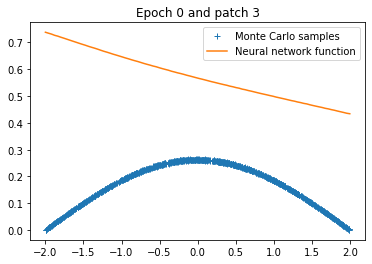

Patch 3: epoch 0 with loss 1.3395674228668213


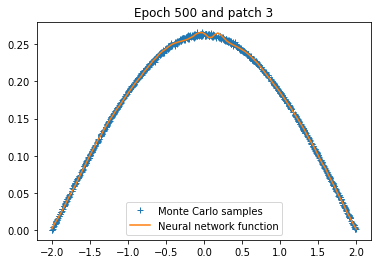

Patch 3: epoch 500 with loss 2.310893933099578e-06


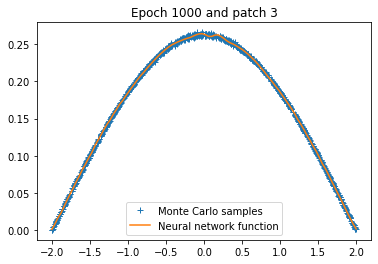

Patch 3: epoch 1000 with loss 1.228140945386258e-06


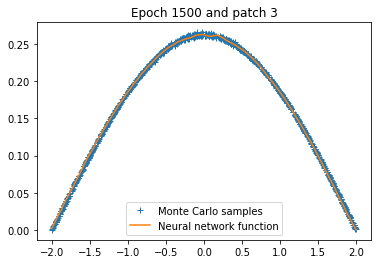

Patch 3: epoch 1500 with loss 1.4318610510599683e-06


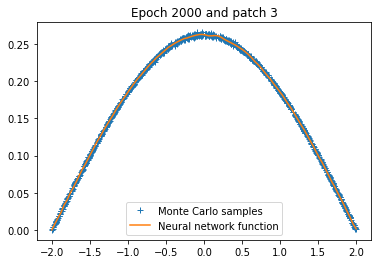

Patch 3: epoch 2000 with loss 1.1854750709971995e-06


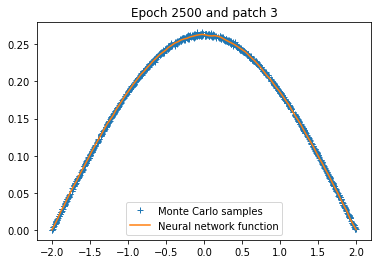

Patch 3: epoch 2500 with loss 8.489308243042615e-07


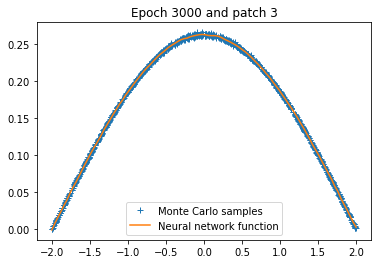

Patch 3: epoch 3000 with loss 8.351278211193858e-07


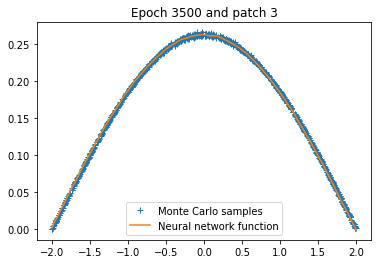

Patch 3: epoch 3500 with loss 1.2112067224734346e-06


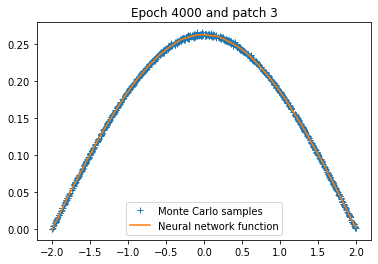

Patch 3: epoch 4000 with loss 8.953663268584933e-07


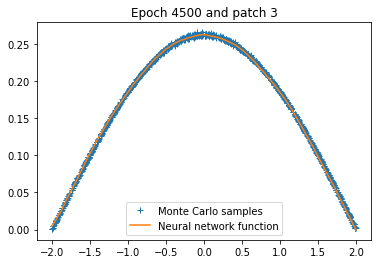

Patch 3: epoch 4500 with loss 1.4674966450911597e-06


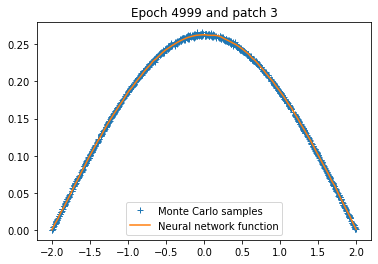

Patch 3: epoch 4999 with loss 8.692446158420353e-07
Patch 3: training of neural network with 5000 epochs take 20.19703960418701 seconds.
Patch 4: generation of samples take 0.6017003059387207 seconds.


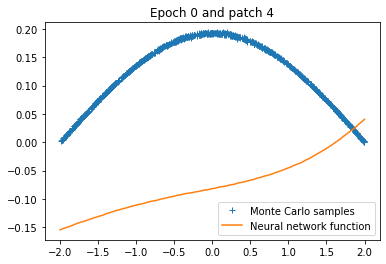

Patch 4: epoch 0 with loss 1.110891342163086


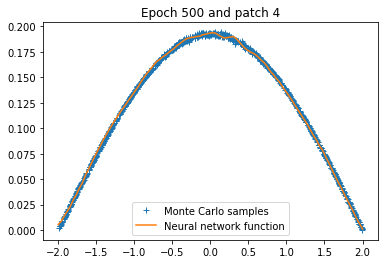

Patch 4: epoch 500 with loss 1.6917691709750216e-06


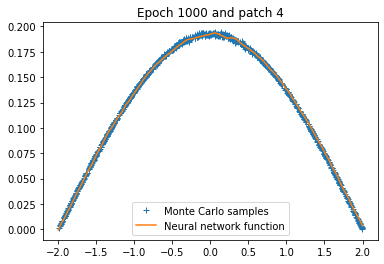

Patch 4: epoch 1000 with loss 2.2868882751936326e-06


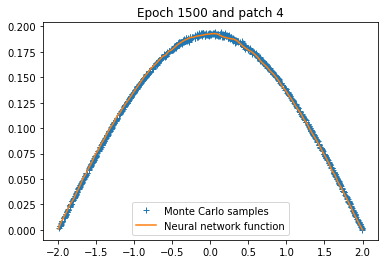

Patch 4: epoch 1500 with loss 1.1831364190584281e-06


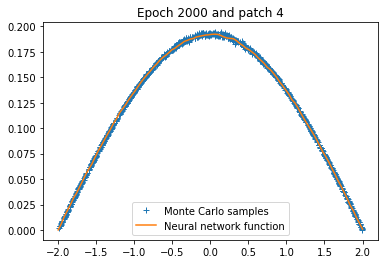

Patch 4: epoch 2000 with loss 9.328975920652738e-07


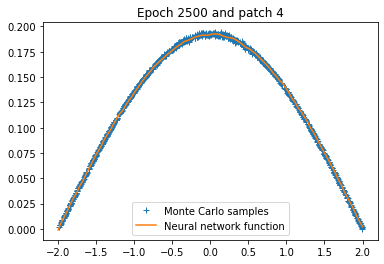

Patch 4: epoch 2500 with loss 5.939145921729505e-07


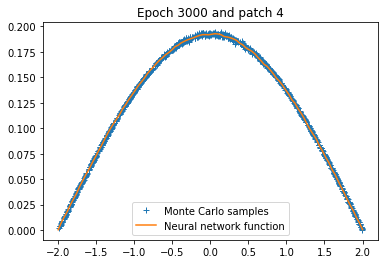

Patch 4: epoch 3000 with loss 5.96686504650279e-07


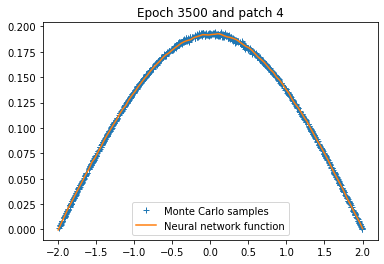

Patch 4: epoch 3500 with loss 5.792968750029104e-06


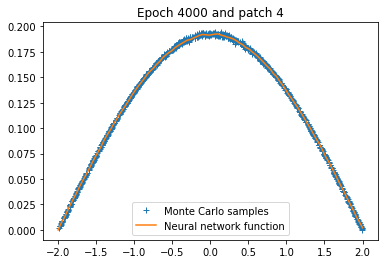

Patch 4: epoch 4000 with loss 6.108613206379232e-07


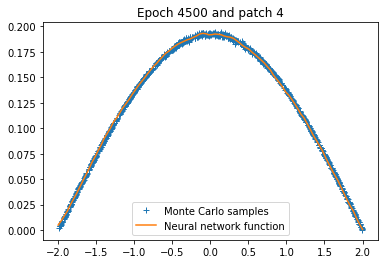

Patch 4: epoch 4500 with loss 8.186929107978358e-07


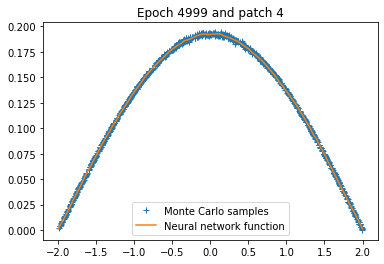

Patch 4: epoch 4999 with loss 6.10314998539252e-07
Patch 4: training of neural network with 5000 epochs take 20.42019557952881 seconds.
Patch 5: generation of samples take 0.6288039684295654 seconds.


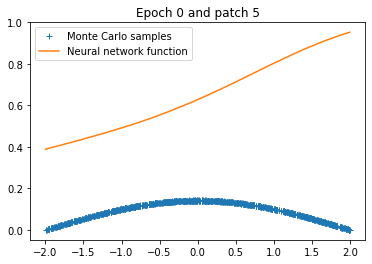

Patch 5: epoch 0 with loss 5.7751359939575195


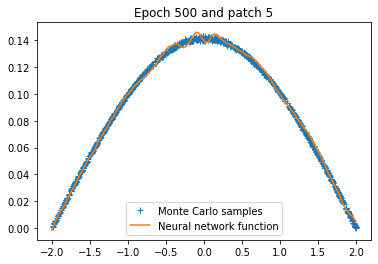

Patch 5: epoch 500 with loss 4.197123871563235e-06


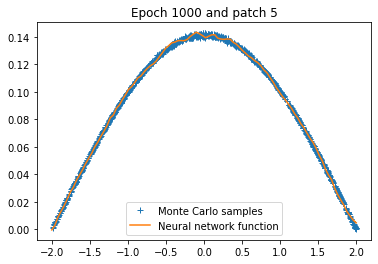

Patch 5: epoch 1000 with loss 2.8554070468089776e-06


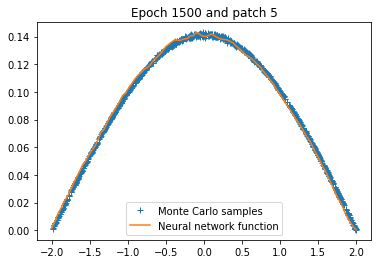

Patch 5: epoch 1500 with loss 2.3688210148975486e-06


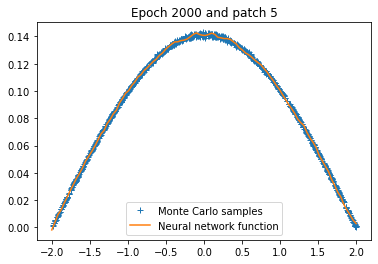

Patch 5: epoch 2000 with loss 2.6345944661443355e-06


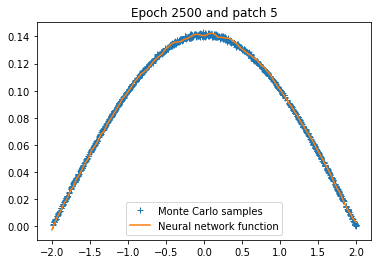

Patch 5: epoch 2500 with loss 7.35210278435261e-07


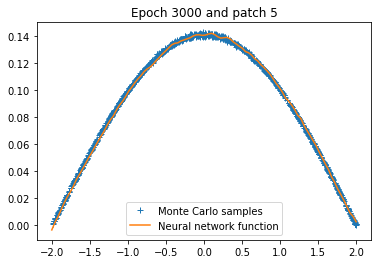

Patch 5: epoch 3000 with loss 6.374770237016492e-06


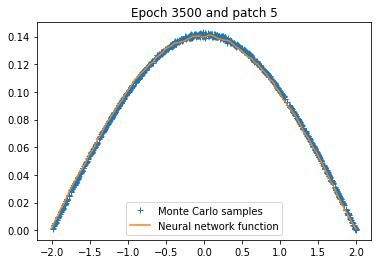

Patch 5: epoch 3500 with loss 2.0400502762640826e-05


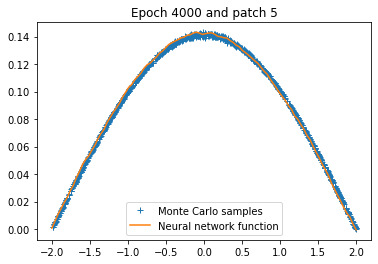

Patch 5: epoch 4000 with loss 1.0420808393973857e-06


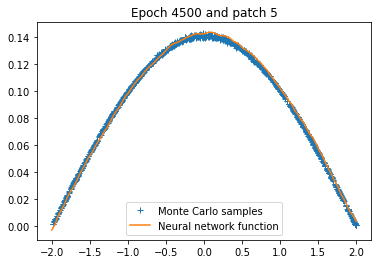

Patch 5: epoch 4500 with loss 2.2841259124106728e-05


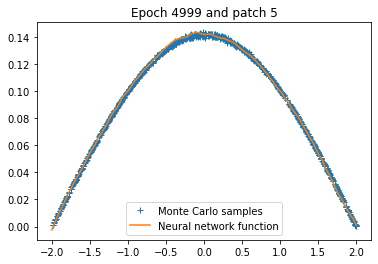

Patch 5: epoch 4999 with loss 1.7826237126428168e-06
Patch 5: training of neural network with 5000 epochs take 20.767984628677368 seconds.
Patch 6: generation of samples take 0.6277346611022949 seconds.


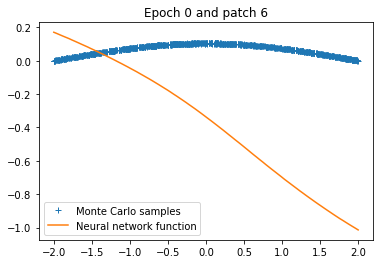

Patch 6: epoch 0 with loss 0.7465671300888062


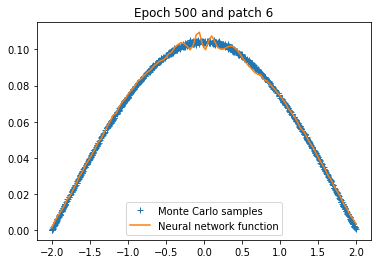

Patch 6: epoch 500 with loss 1.768502215782064e-06


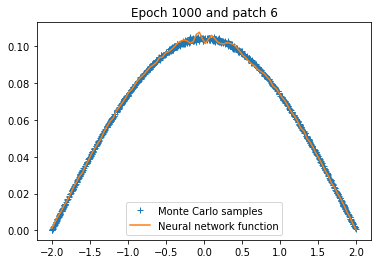

Patch 6: epoch 1000 with loss 9.365544428874273e-07


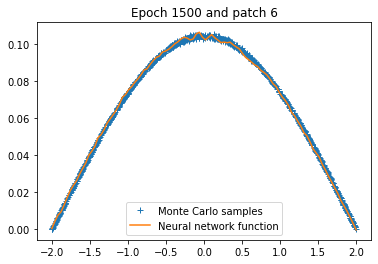

Patch 6: epoch 1500 with loss 5.124948643242533e-07


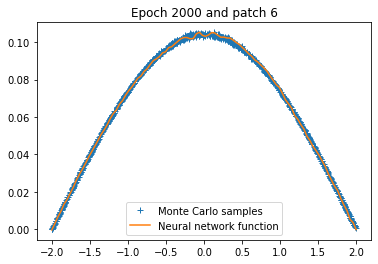

Patch 6: epoch 2000 with loss 4.130379693378927e-06


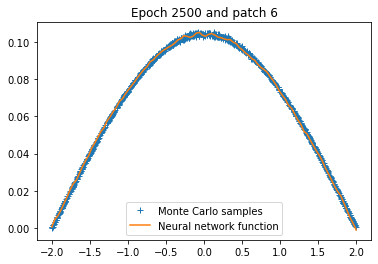

Patch 6: epoch 2500 with loss 6.742093319189735e-07


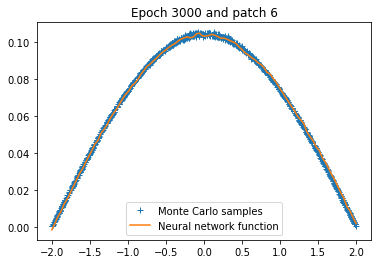

Patch 6: epoch 3000 with loss 4.3983195041619183e-07


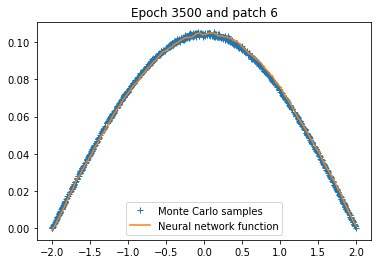

Patch 6: epoch 3500 with loss 1.2451420161596616e-06


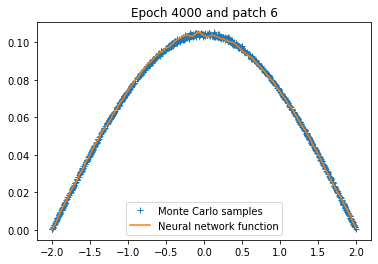

Patch 6: epoch 4000 with loss 4.290700985620788e-07


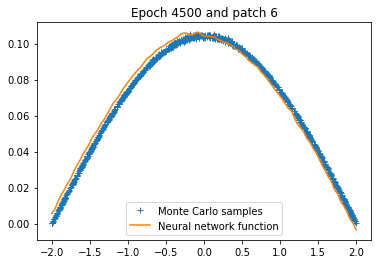

Patch 6: epoch 4500 with loss 2.2442536646849476e-06


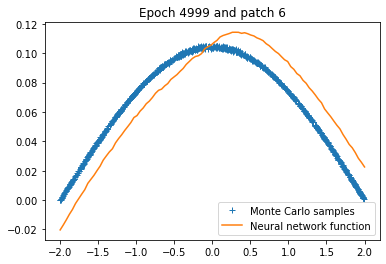

Patch 6: epoch 4999 with loss 0.00017267357907257974
Patch 6: training of neural network with 5000 epochs take 20.466192722320557 seconds.
Patch 7: generation of samples take 0.6272323131561279 seconds.


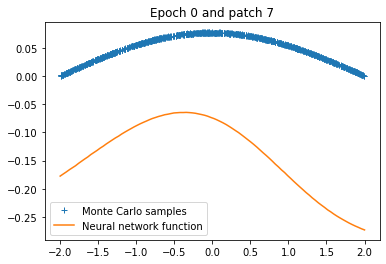

Patch 7: epoch 0 with loss 2.2115895748138428


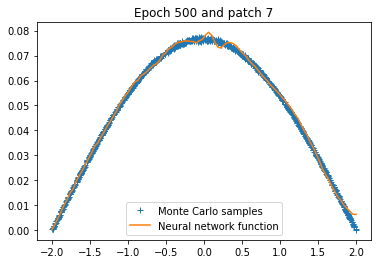

Patch 7: epoch 500 with loss 1.1458938615760417e-06


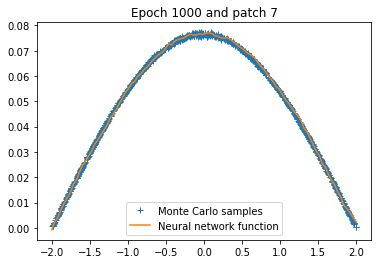

Patch 7: epoch 1000 with loss 1.9608185084507568e-06


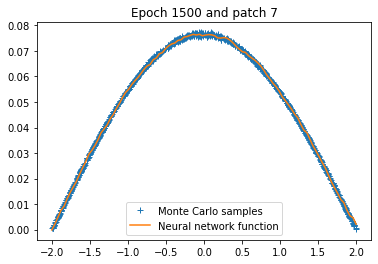

Patch 7: epoch 1500 with loss 2.3132569992867502e-07


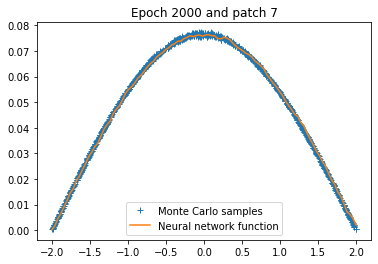

Patch 7: epoch 2000 with loss 1.263446279153868e-06


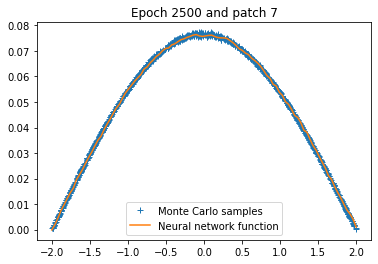

Patch 7: epoch 2500 with loss 3.976251718995627e-07


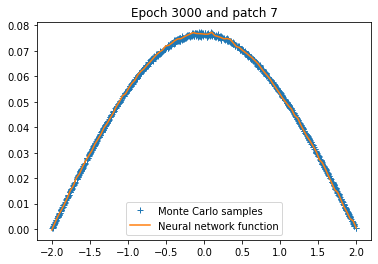

Patch 7: epoch 3000 with loss 4.925923349219374e-07


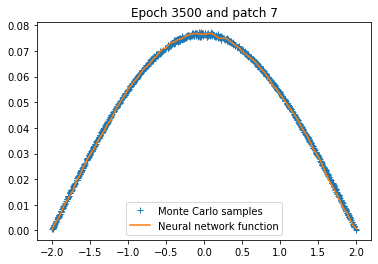

Patch 7: epoch 3500 with loss 6.12344649653096e-07


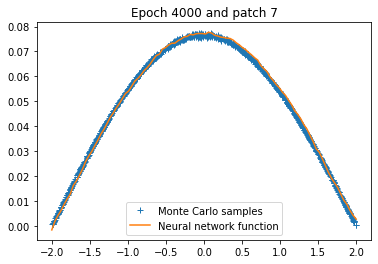

Patch 7: epoch 4000 with loss 1.9361123122507706e-06


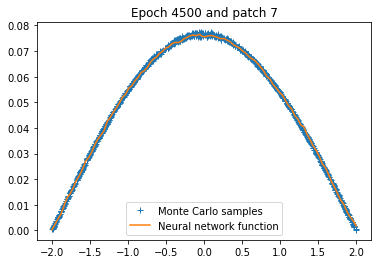

Patch 7: epoch 4500 with loss 2.7452571771391376e-07


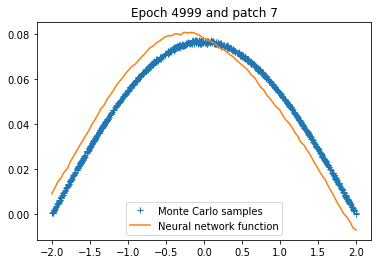

Patch 7: epoch 4999 with loss 2.6005662220995873e-05
Patch 7: training of neural network with 5000 epochs take 20.593668699264526 seconds.
Patch 8: generation of samples take 0.6599903106689453 seconds.


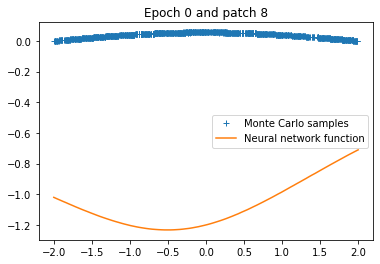

Patch 8: epoch 0 with loss 0.3379201889038086


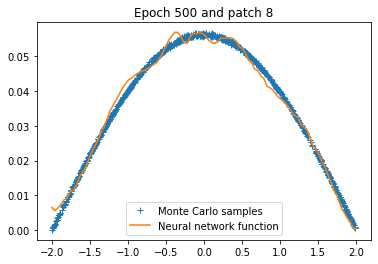

Patch 8: epoch 500 with loss 4.905380592390429e-06


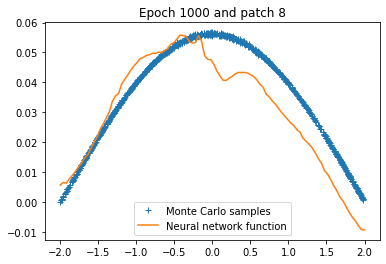

Patch 8: epoch 1000 with loss 8.026273462746758e-06


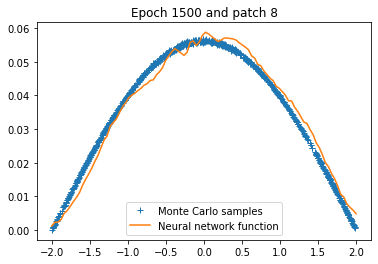

Patch 8: epoch 1500 with loss 1.6590811355854385e-06


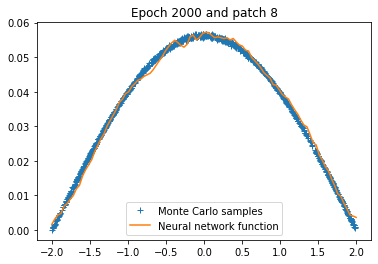

Patch 8: epoch 2000 with loss 5.808313289890066e-06


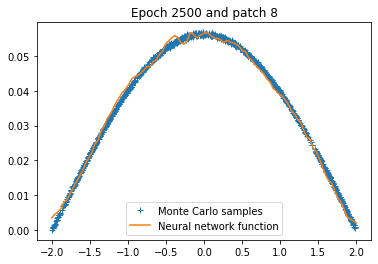

Patch 8: epoch 2500 with loss 3.6805074614676414e-06


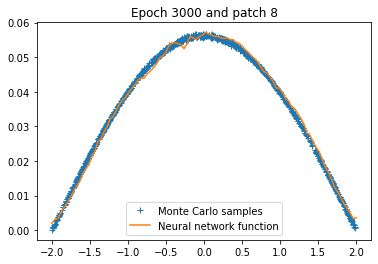

Patch 8: epoch 3000 with loss 1.3159007039575954e-06


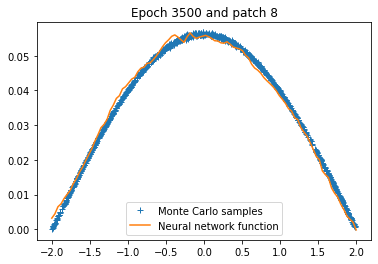

Patch 8: epoch 3500 with loss 2.7496939765114803e-06


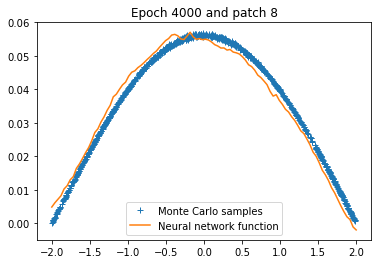

Patch 8: epoch 4000 with loss 9.00187387742335e-06


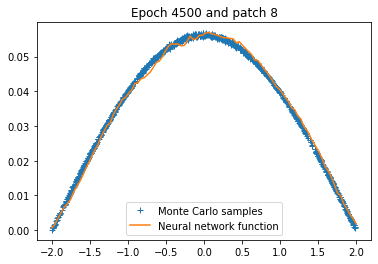

Patch 8: epoch 4500 with loss 8.901712931219663e-07


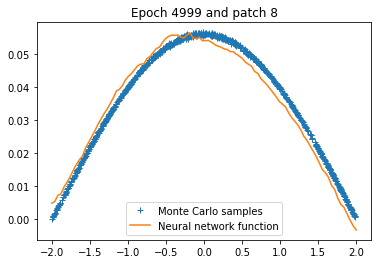

Patch 8: epoch 4999 with loss 1.5619583791703917e-05
Patch 8: training of neural network with 5000 epochs take 21.196319580078125 seconds.
Patch 9: generation of samples take 0.6529092788696289 seconds.


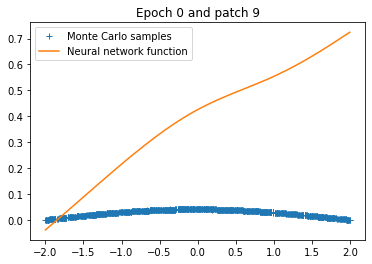

Patch 9: epoch 0 with loss 10.969351768493652


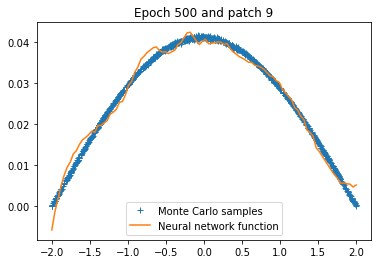

Patch 9: epoch 500 with loss 2.5644601464591688e-06


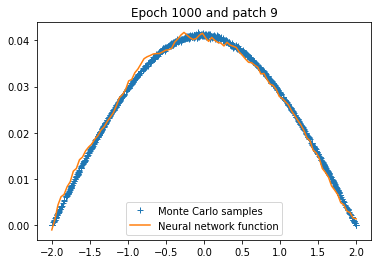

Patch 9: epoch 1000 with loss 1.1366076932972646e-06


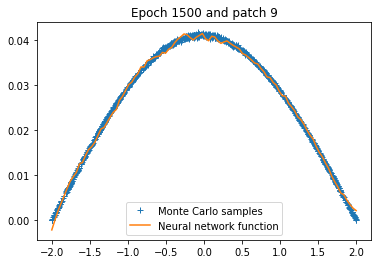

Patch 9: epoch 1500 with loss 3.112023136964126e-07


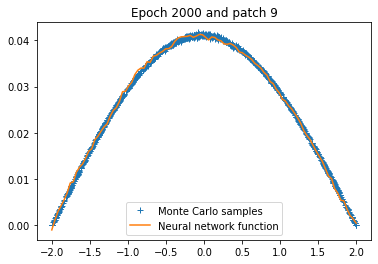

Patch 9: epoch 2000 with loss 1.9827827202334447e-07


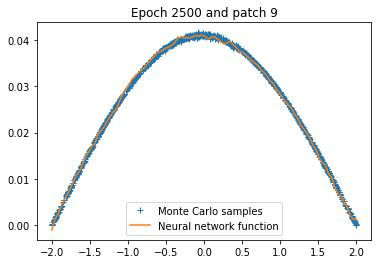

Patch 9: epoch 2500 with loss 1.5194264335605112e-07


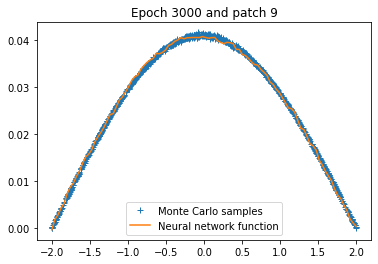

Patch 9: epoch 3000 with loss 1.3196617487665208e-07


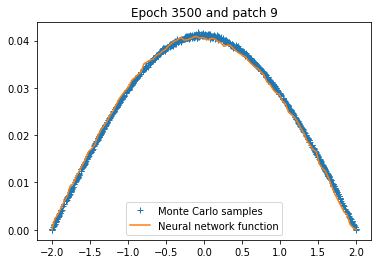

Patch 9: epoch 3500 with loss 1.5010915888069576e-07


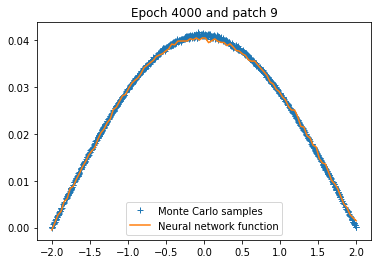

Patch 9: epoch 4000 with loss 3.389830283140327e-07


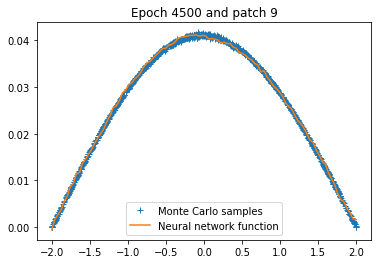

Patch 9: epoch 4500 with loss 2.058510233382549e-07


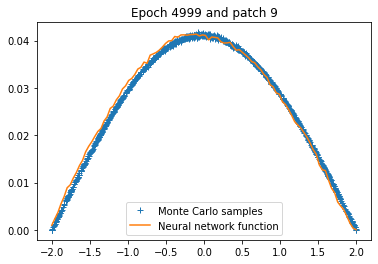

Patch 9: epoch 4999 with loss 7.07740923644451e-07
Patch 9: training of neural network with 5000 epochs take 21.152942657470703 seconds.


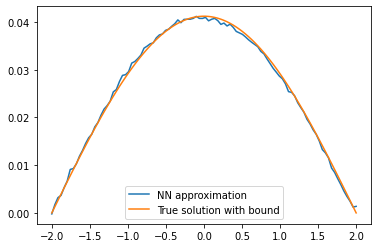

In [8]:
torch.manual_seed(0)

# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
# plt.plot(grid, true, label="True solution without bound")
plt.plot(grid, true_with_bound, label="True solution with bound")
plt.legend()
plt.show()

## Example 2: Kuramoto equation 5

In [18]:
alpha, gamma = 1, 1

# function definition
deriv_map = np.array([0, 1, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> forth deriv
    """
    return y[0] * y[1] + gamma * y[2]

def phi_example(x):
    return torch.exp(-x[0]**2)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

patches = 10
T = patches * .1

Patch 0: generation of samples take 1.610029697418213 seconds.


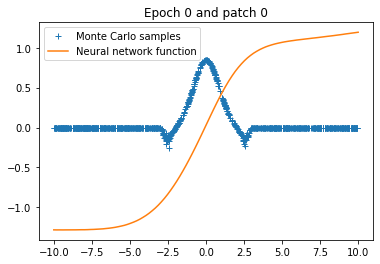

Patch 0: epoch 0 with loss 7.349950313568115


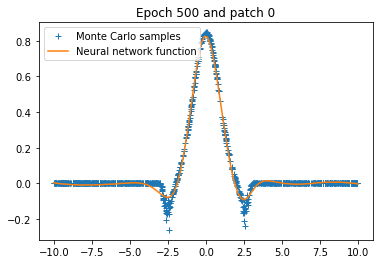

Patch 0: epoch 500 with loss 0.00036450420157052577


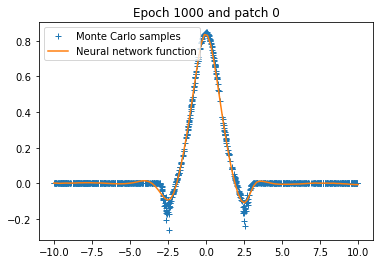

Patch 0: epoch 1000 with loss 0.00022802954481448978


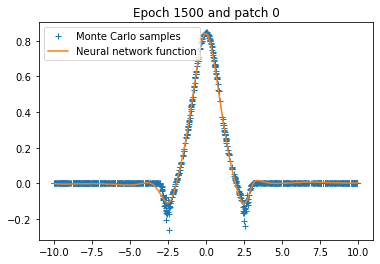

Patch 0: epoch 1500 with loss 0.00018370244652032852


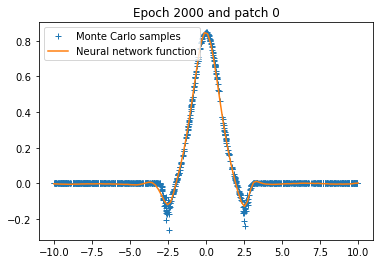

Patch 0: epoch 2000 with loss 0.00013006976223550737


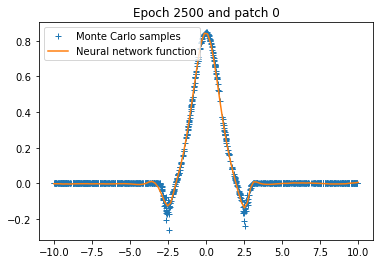

Patch 0: epoch 2500 with loss 0.000103889120509848


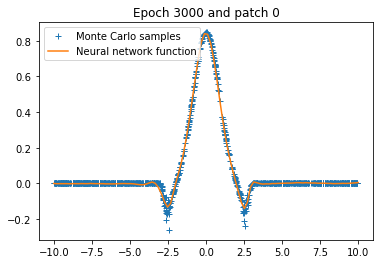

Patch 0: epoch 3000 with loss 9.239924111170694e-05


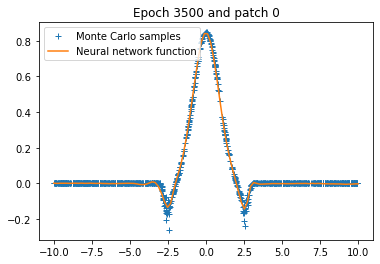

Patch 0: epoch 3500 with loss 9.069544466910884e-05


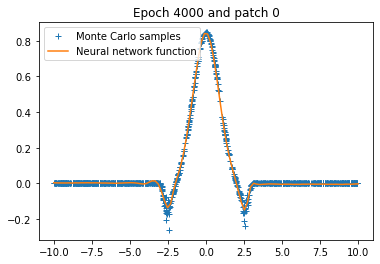

Patch 0: epoch 4000 with loss 9.909521759254858e-05


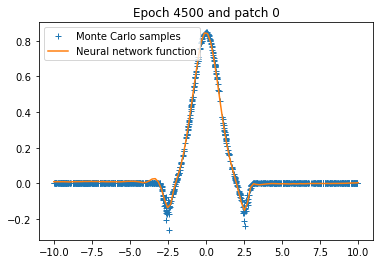

Patch 0: epoch 4500 with loss 0.0001243408041773364


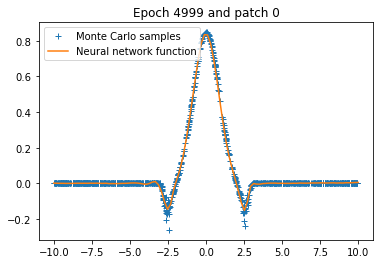

Patch 0: epoch 4999 with loss 8.467439329251647e-05
Patch 0: training of neural network with 5000 epochs take 26.171342849731445 seconds.
Patch 1: generation of samples take 5.691176652908325 seconds.


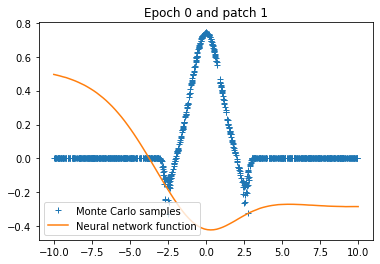

Patch 1: epoch 0 with loss 5.079821586608887


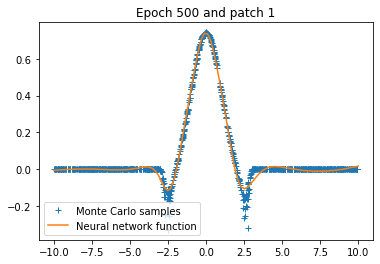

Patch 1: epoch 500 with loss 0.0005201384774409235


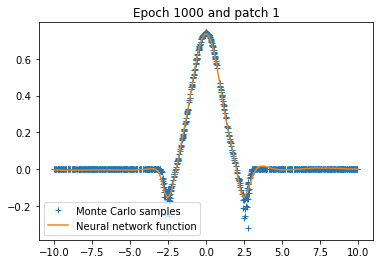

Patch 1: epoch 1000 with loss 0.0002791092556435615


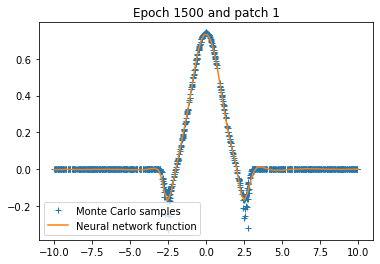

Patch 1: epoch 1500 with loss 0.0002019222010858357


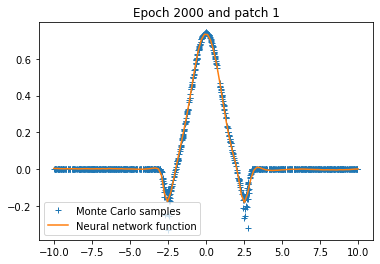

Patch 1: epoch 2000 with loss 0.000182955976924859


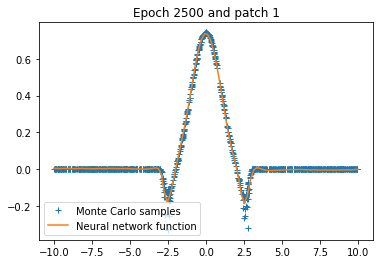

Patch 1: epoch 2500 with loss 0.00016957875050138682


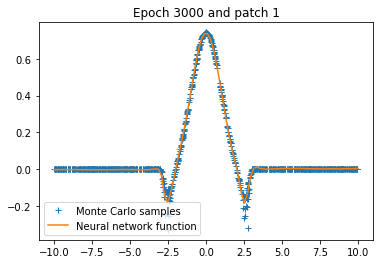

Patch 1: epoch 3000 with loss 0.00016568208229728043


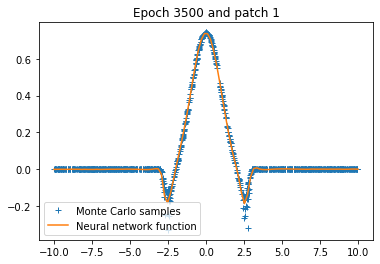

Patch 1: epoch 3500 with loss 0.0001605687284609303


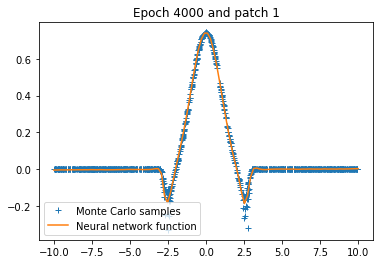

Patch 1: epoch 4000 with loss 0.0001663719303905964


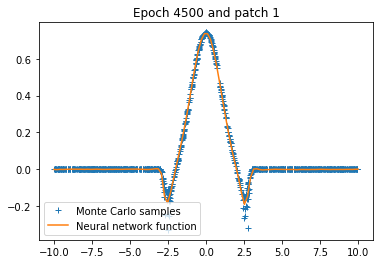

Patch 1: epoch 4500 with loss 0.00016293168300762773


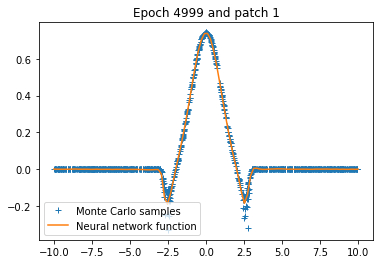

Patch 1: epoch 4999 with loss 0.00015624154184479266
Patch 1: training of neural network with 5000 epochs take 24.0492160320282 seconds.
Patch 2: generation of samples take 4.978959798812866 seconds.


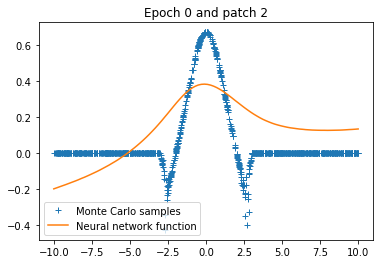

Patch 2: epoch 0 with loss 1.7434691190719604


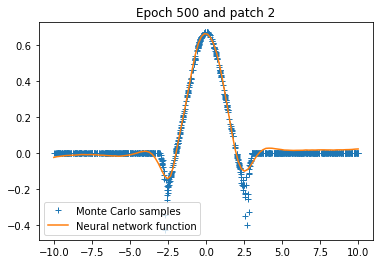

Patch 2: epoch 500 with loss 0.0007234927616082132


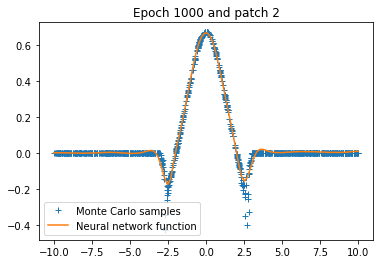

Patch 2: epoch 1000 with loss 0.0004178874660283327


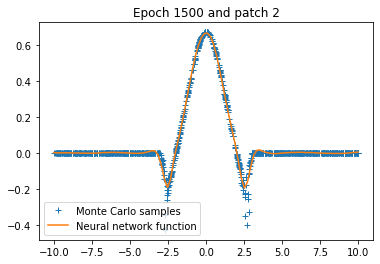

Patch 2: epoch 1500 with loss 0.00031856884015724063


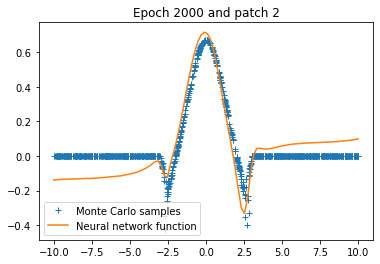

Patch 2: epoch 2000 with loss 0.0034681952092796564


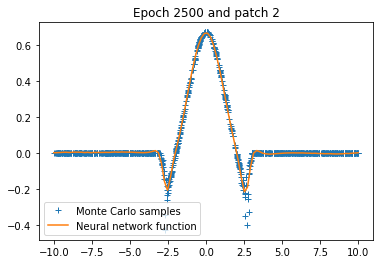

Patch 2: epoch 2500 with loss 0.00025351456133648753


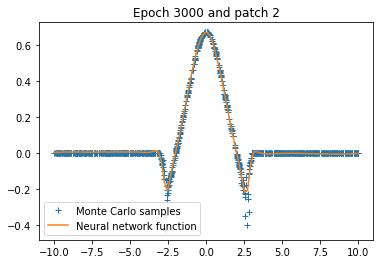

Patch 2: epoch 3000 with loss 0.000225996263907291


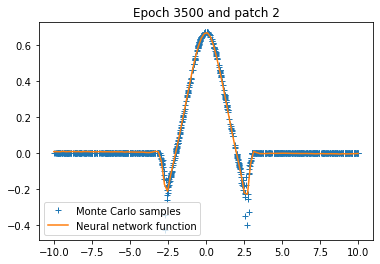

Patch 2: epoch 3500 with loss 0.00021375325741246343


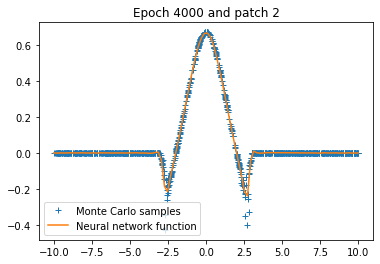

Patch 2: epoch 4000 with loss 0.00018661655485630035


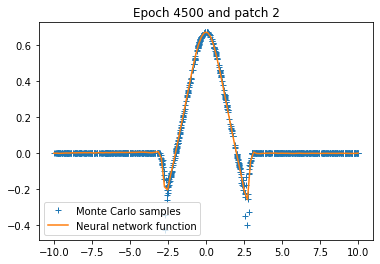

Patch 2: epoch 4500 with loss 0.00017734857101459056


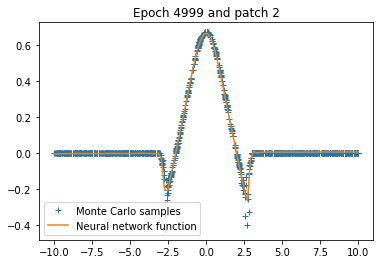

Patch 2: epoch 4999 with loss 0.00017688462685327977
Patch 2: training of neural network with 5000 epochs take 30.118369817733765 seconds.
Patch 3: generation of samples take 6.474772930145264 seconds.


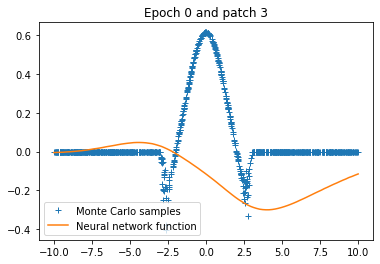

Patch 3: epoch 0 with loss 4.679110527038574


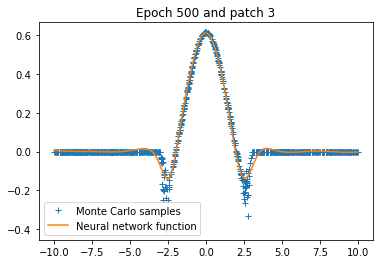

Patch 3: epoch 500 with loss 0.0004708255873993039


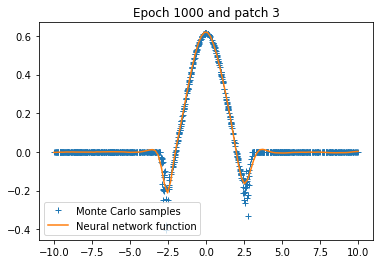

Patch 3: epoch 1000 with loss 0.0002892426564358175


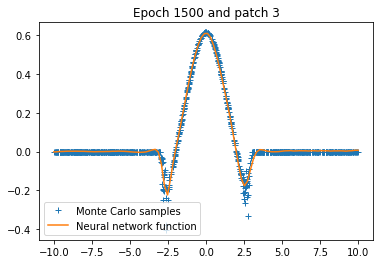

Patch 3: epoch 1500 with loss 0.00023223049356602132


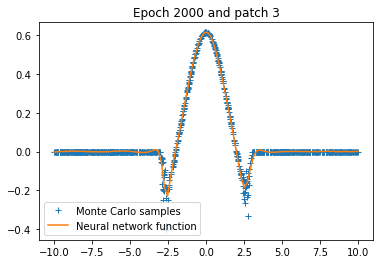

Patch 3: epoch 2000 with loss 0.00021279940847307444


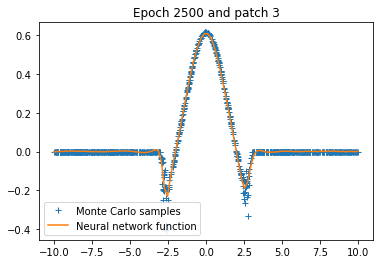

Patch 3: epoch 2500 with loss 0.00020425037655513734


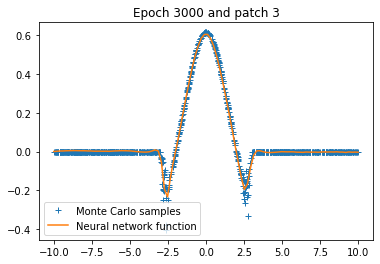

Patch 3: epoch 3000 with loss 0.0002277293970109895


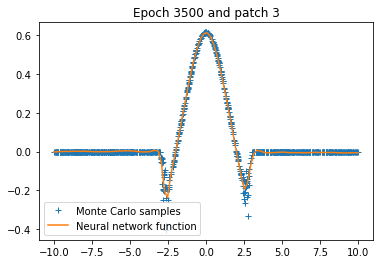

Patch 3: epoch 3500 with loss 0.00019734616216737777


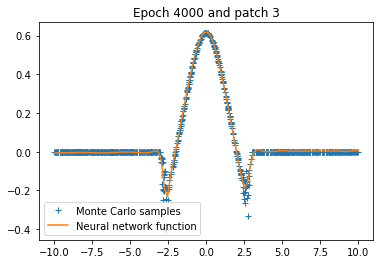

Patch 3: epoch 4000 with loss 0.0002010299067478627


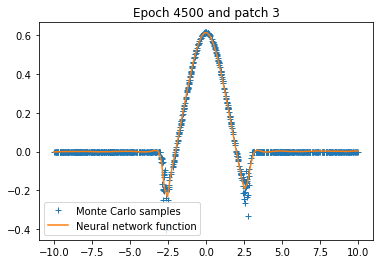

Patch 3: epoch 4500 with loss 0.0001944922551047057


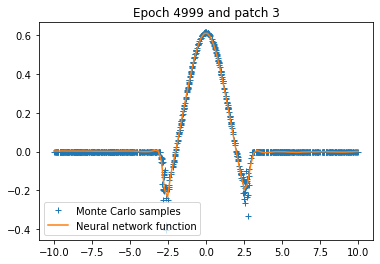

Patch 3: epoch 4999 with loss 0.00020191926159895957
Patch 3: training of neural network with 5000 epochs take 21.264551162719727 seconds.
Patch 4: generation of samples take 3.852834701538086 seconds.


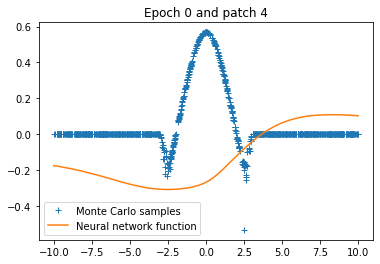

Patch 4: epoch 0 with loss 0.3831512928009033


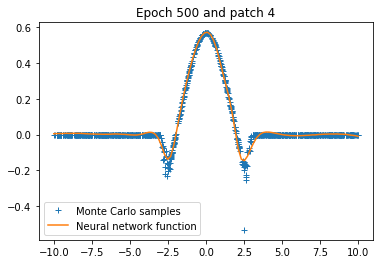

Patch 4: epoch 500 with loss 0.0003440397558733821


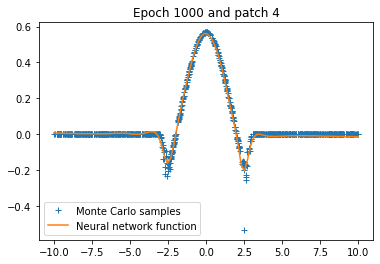

Patch 4: epoch 1000 with loss 0.0002316530590178445


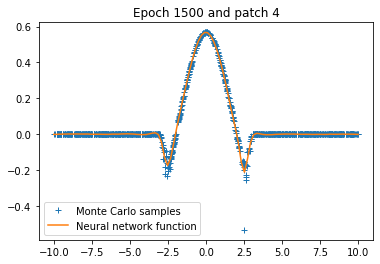

Patch 4: epoch 1500 with loss 0.000174462707946077


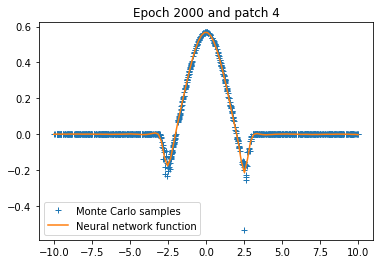

Patch 4: epoch 2000 with loss 0.0001730328513076529


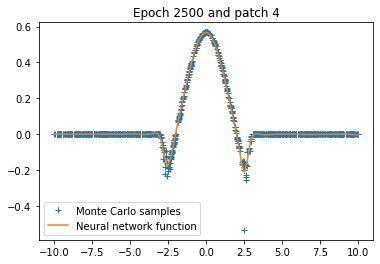

Patch 4: epoch 2500 with loss 0.00017250840028282255


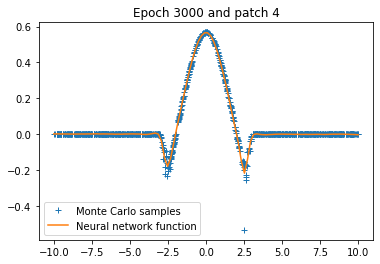

Patch 4: epoch 3000 with loss 0.0001705583999864757


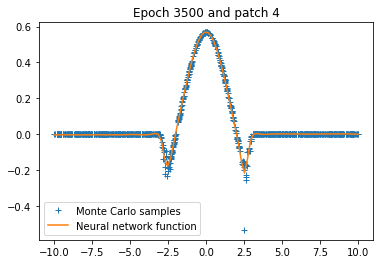

Patch 4: epoch 3500 with loss 0.00017377307813148946


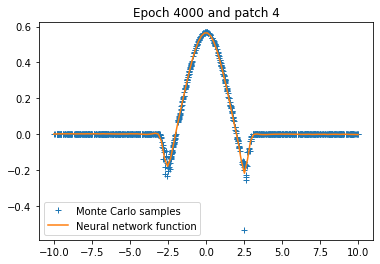

Patch 4: epoch 4000 with loss 0.0001721115258987993


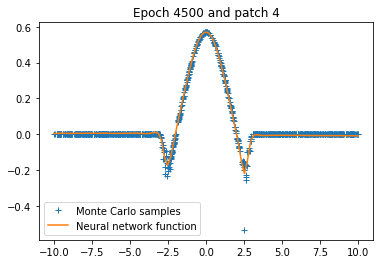

Patch 4: epoch 4500 with loss 0.00018797161465045065


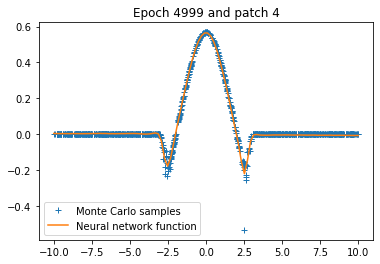

Patch 4: epoch 4999 with loss 0.00017100606055464596
Patch 4: training of neural network with 5000 epochs take 20.150026559829712 seconds.
Patch 5: generation of samples take 4.040656089782715 seconds.


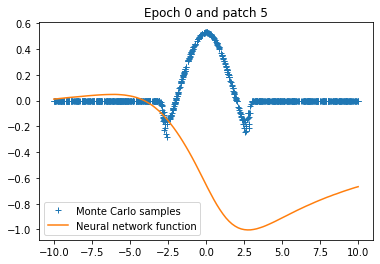

Patch 5: epoch 0 with loss 0.3283827006816864


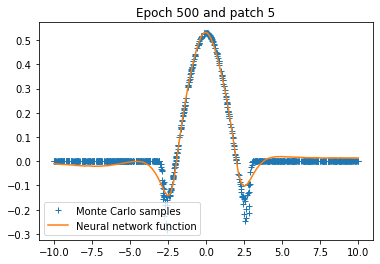

Patch 5: epoch 500 with loss 0.00038930209120735526


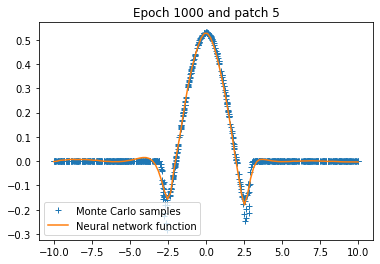

Patch 5: epoch 1000 with loss 0.00016813786351121962


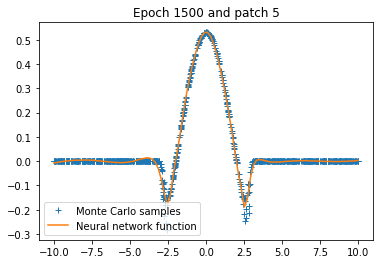

Patch 5: epoch 1500 with loss 0.00013027981913182884


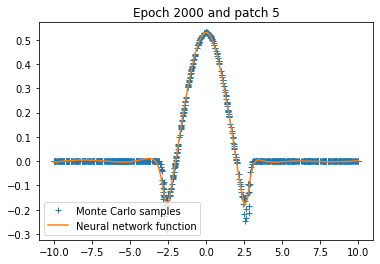

Patch 5: epoch 2000 with loss 0.00011983231524936855


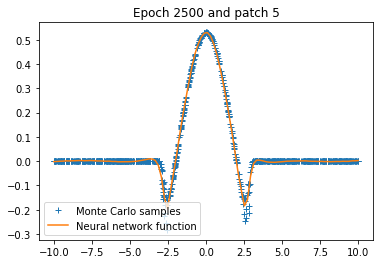

Patch 5: epoch 2500 with loss 9.279030928155407e-05


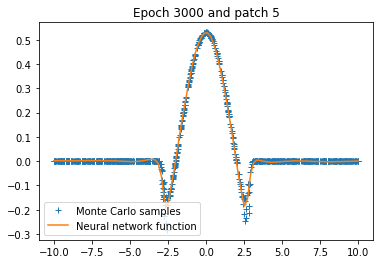

Patch 5: epoch 3000 with loss 8.412534225499257e-05


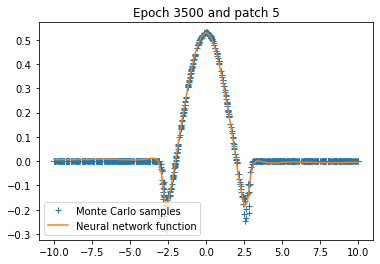

Patch 5: epoch 3500 with loss 0.00011344020458636805


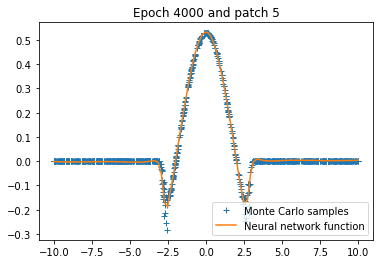

Patch 5: epoch 4000 with loss 8.276404696516693e-05


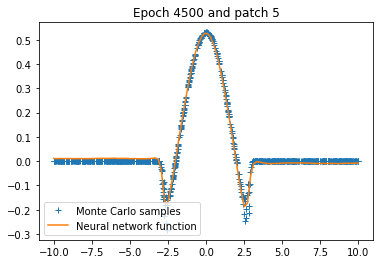

Patch 5: epoch 4500 with loss 0.0001265838072868064


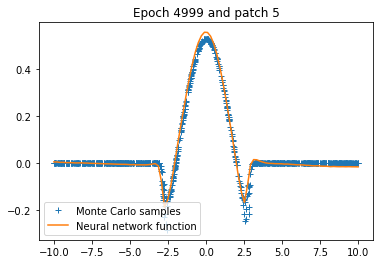

Patch 5: epoch 4999 with loss 0.00014203156752046198
Patch 5: training of neural network with 5000 epochs take 24.51444697380066 seconds.
Patch 6: generation of samples take 6.714064121246338 seconds.


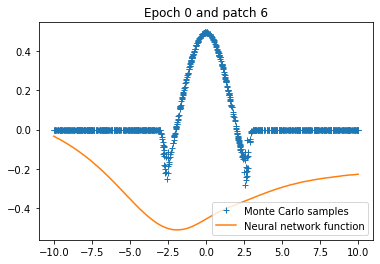

Patch 6: epoch 0 with loss 1.5342000722885132


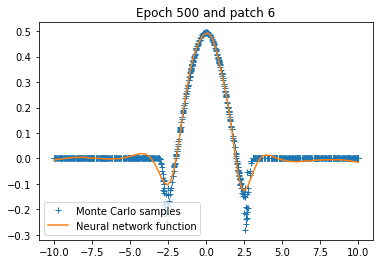

Patch 6: epoch 500 with loss 0.00038490621955133975


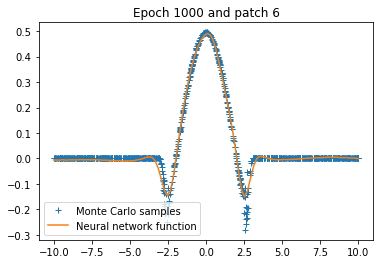

Patch 6: epoch 1000 with loss 0.0002151739754481241


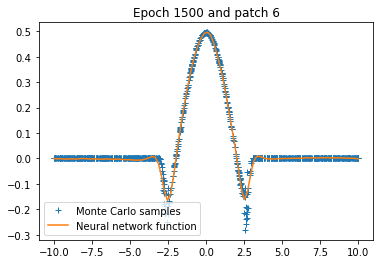

Patch 6: epoch 1500 with loss 0.00015755323693156242


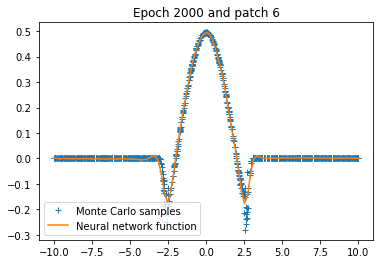

Patch 6: epoch 2000 with loss 0.00013189487799536437


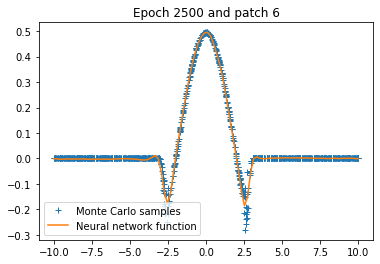

Patch 6: epoch 2500 with loss 0.00011048202577512711


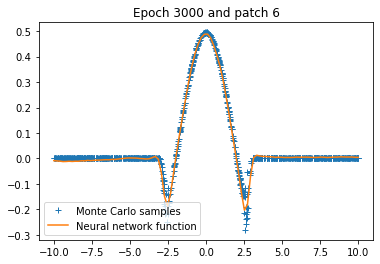

Patch 6: epoch 3000 with loss 0.00017101524281315506


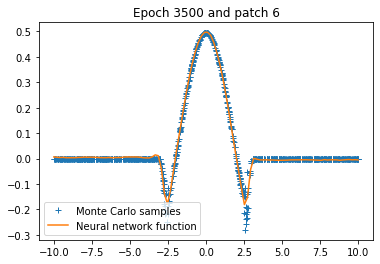

Patch 6: epoch 3500 with loss 9.506590868113562e-05


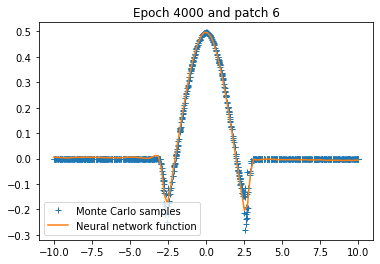

Patch 6: epoch 4000 with loss 0.00011904558778041974


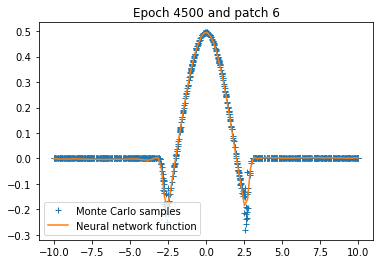

Patch 6: epoch 4500 with loss 8.55380785651505e-05


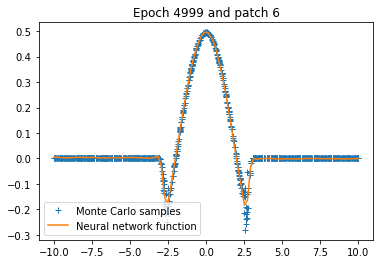

Patch 6: epoch 4999 with loss 8.47533083287999e-05
Patch 6: training of neural network with 5000 epochs take 23.07128119468689 seconds.
Patch 7: generation of samples take 4.9373979568481445 seconds.


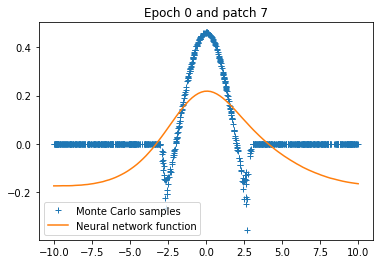

Patch 7: epoch 0 with loss 5.946298122406006


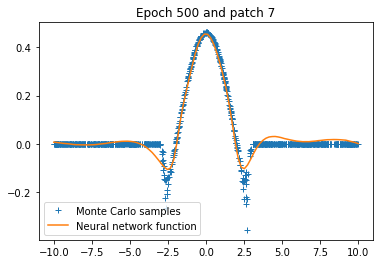

Patch 7: epoch 500 with loss 0.0005186536000110209


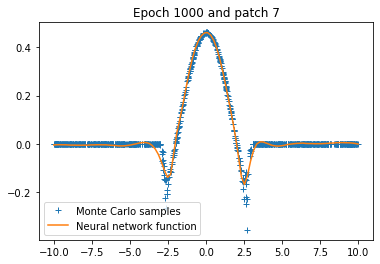

Patch 7: epoch 1000 with loss 0.00020029024744872004


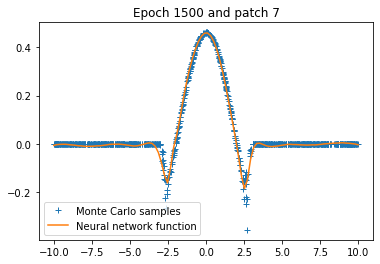

Patch 7: epoch 1500 with loss 0.00014386327529791743


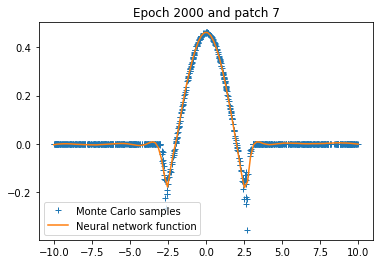

Patch 7: epoch 2000 with loss 0.00011463182454463094


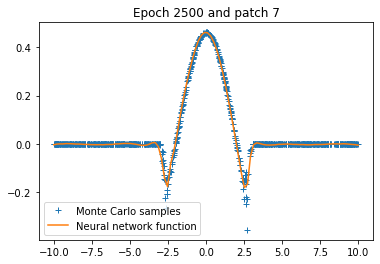

Patch 7: epoch 2500 with loss 0.00011157160042785108


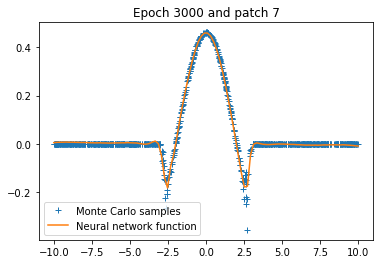

Patch 7: epoch 3000 with loss 0.00012754593626596034


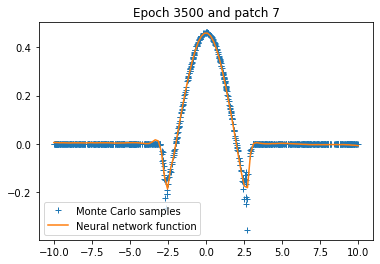

Patch 7: epoch 3500 with loss 9.814396617002785e-05


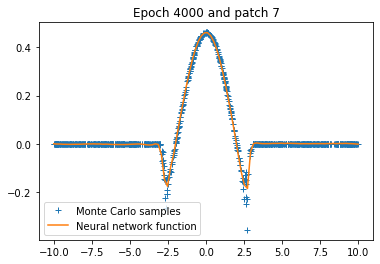

Patch 7: epoch 4000 with loss 8.60650761751458e-05


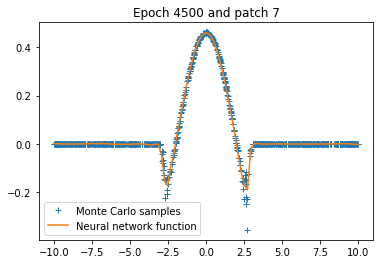

Patch 7: epoch 4500 with loss 8.227462240029126e-05


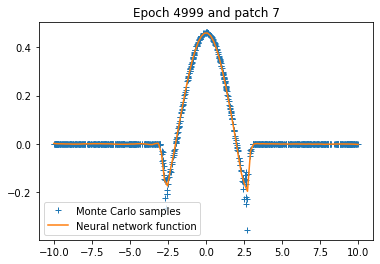

Patch 7: epoch 4999 with loss 7.860679761506617e-05
Patch 7: training of neural network with 5000 epochs take 24.89271354675293 seconds.
Patch 8: generation of samples take 4.371016025543213 seconds.


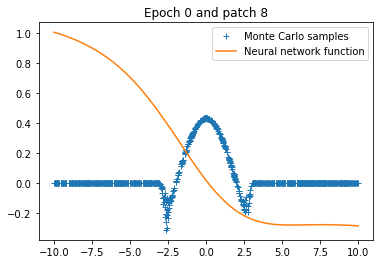

Patch 8: epoch 0 with loss 1.3640788793563843


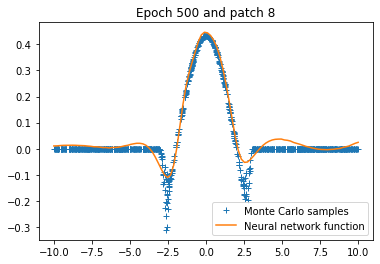

Patch 8: epoch 500 with loss 0.0005557386903092265


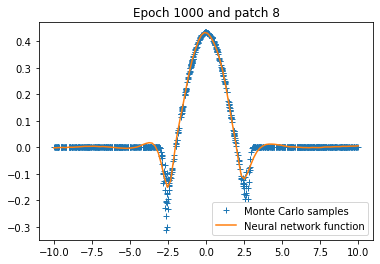

Patch 8: epoch 1000 with loss 0.0002244167117169127


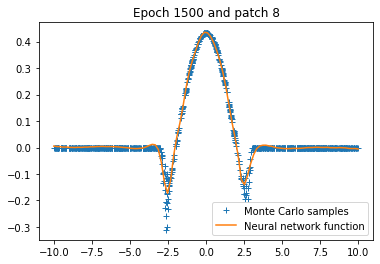

Patch 8: epoch 1500 with loss 0.00015439995331689715


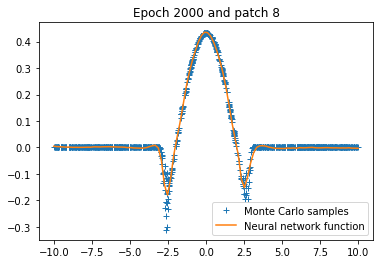

Patch 8: epoch 2000 with loss 0.00013289392518345267


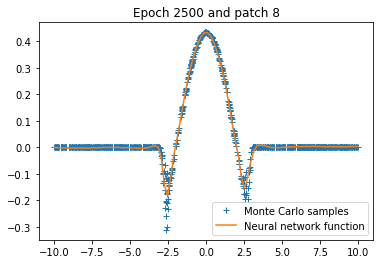

Patch 8: epoch 2500 with loss 0.0001225809392053634


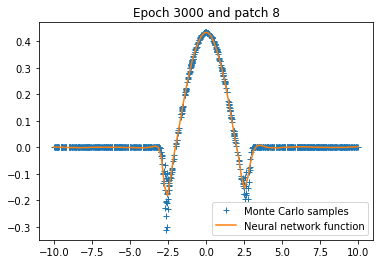

Patch 8: epoch 3000 with loss 0.00011528311006259173


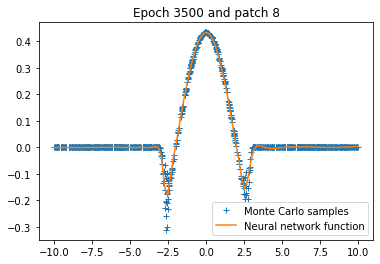

Patch 8: epoch 3500 with loss 0.00011093130888184533


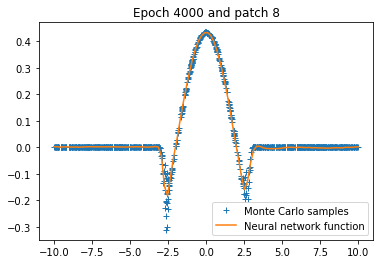

Patch 8: epoch 4000 with loss 0.0001126189308706671


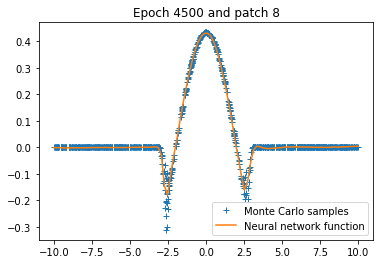

Patch 8: epoch 4500 with loss 0.00011218202416785061


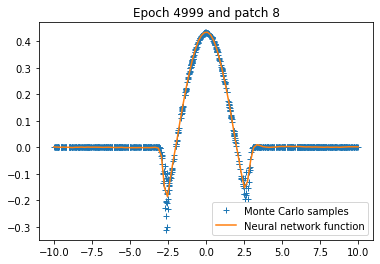

Patch 8: epoch 4999 with loss 0.00011005646956618875
Patch 8: training of neural network with 5000 epochs take 25.068533420562744 seconds.
Patch 9: generation of samples take 6.2217254638671875 seconds.


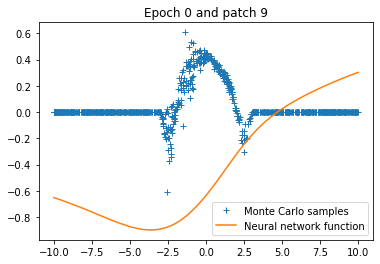

Patch 9: epoch 0 with loss 0.48417776823043823


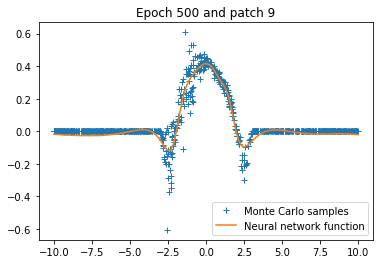

Patch 9: epoch 500 with loss 0.0018154472345486283


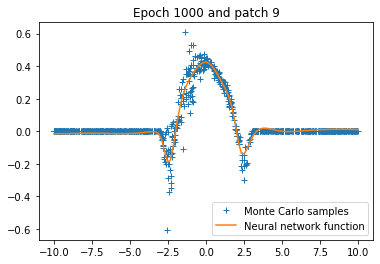

Patch 9: epoch 1000 with loss 0.0014558375114575028


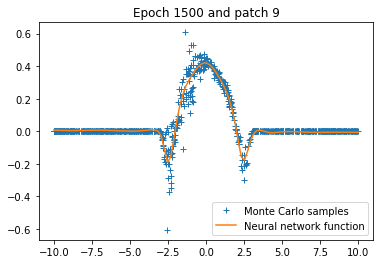

Patch 9: epoch 1500 with loss 0.0014077003579586744


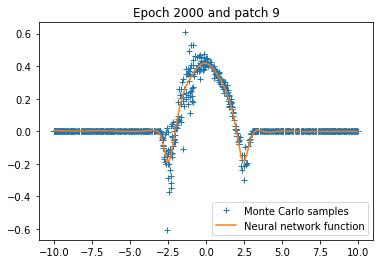

Patch 9: epoch 2000 with loss 0.0013953264569863677


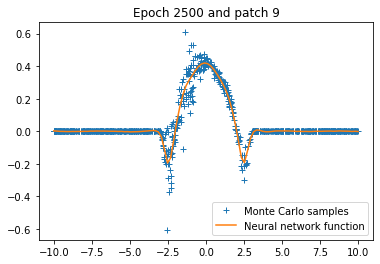

Patch 9: epoch 2500 with loss 0.0013869235990568995


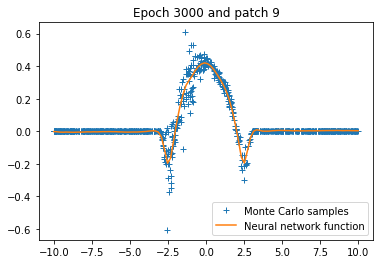

Patch 9: epoch 3000 with loss 0.0013861212646588683


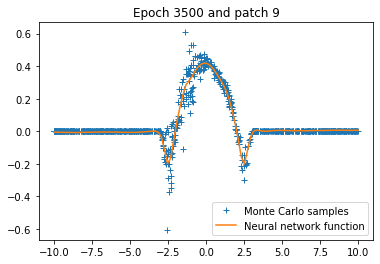

Patch 9: epoch 3500 with loss 0.001378600369207561


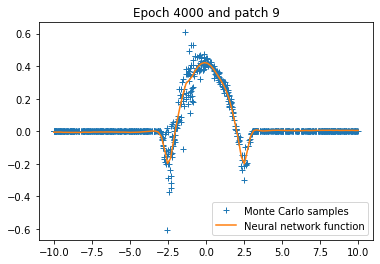

Patch 9: epoch 4000 with loss 0.0013781740562990308


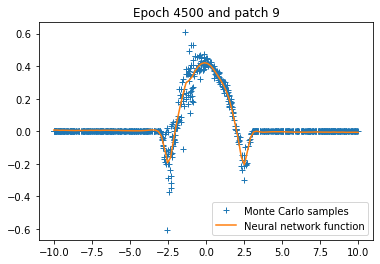

Patch 9: epoch 4500 with loss 0.0013745754258707166


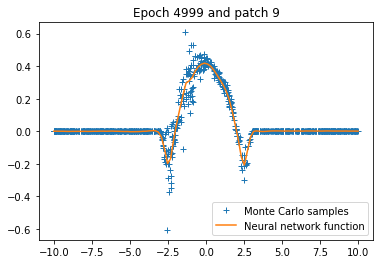

Patch 9: epoch 4999 with loss 0.0013702953001484275
Patch 9: training of neural network with 5000 epochs take 21.490774869918823 seconds.


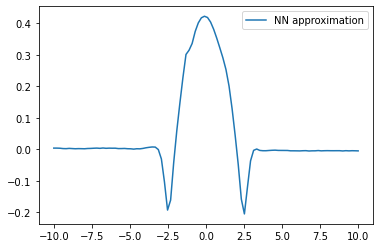

In [17]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.legend()
plt.show()

# Implementation with DGM

We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{cases}
$$

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [5]:
y, eps = 1, 2e-1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return 1 - np.exp(((y - x[0])**2 - (4 - x[0] - y)**2)/(2 * (T - t)))

t_lo, x_lo, x_hi, n = 0., -1., 2., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

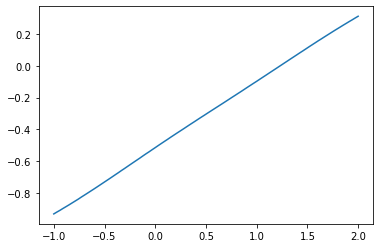

Epoch 0 with loss 4.368678569793701


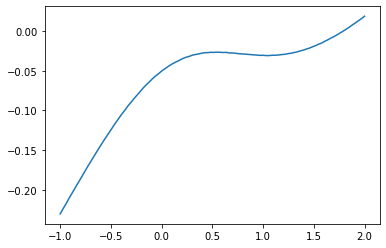

Epoch 500 with loss 0.11923092603683472


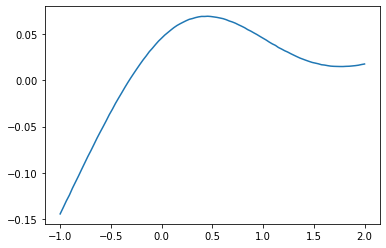

Epoch 1000 with loss 0.1096392348408699


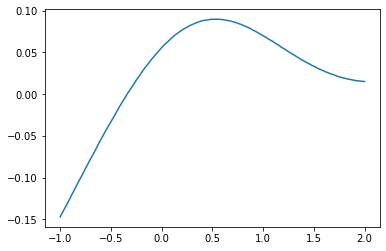

Epoch 1500 with loss 0.10495362430810928


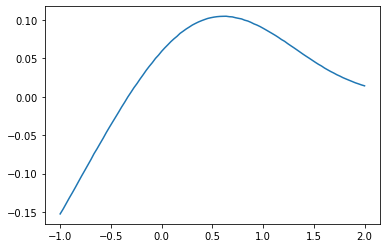

Epoch 2000 with loss 0.10371804982423782


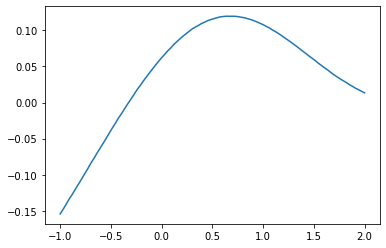

Epoch 2500 with loss 0.10179402679204941


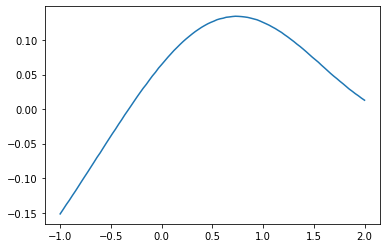

Epoch 3000 with loss 0.09844131022691727


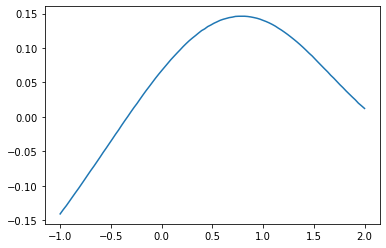

Epoch 3500 with loss 0.09383401274681091


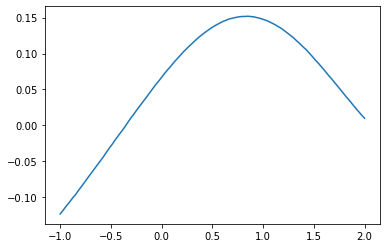

Epoch 4000 with loss 0.09355247765779495


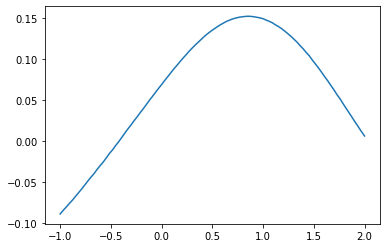

Epoch 4500 with loss 0.09043486416339874


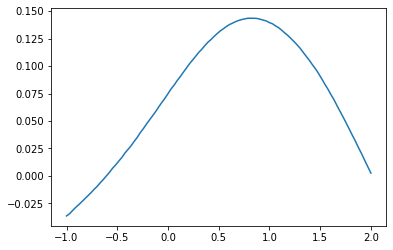

Epoch 5000 with loss 0.08446547389030457


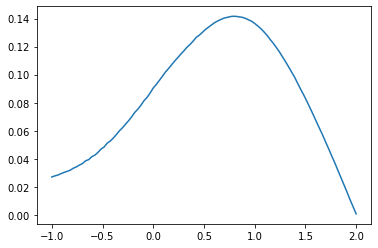

Epoch 5500 with loss 0.07782397419214249


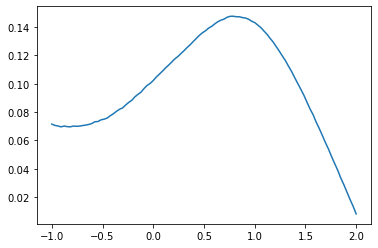

Epoch 6000 with loss 0.07417459040880203


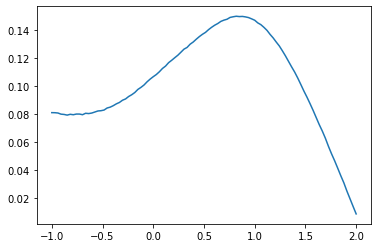

Epoch 6500 with loss 0.07086066156625748


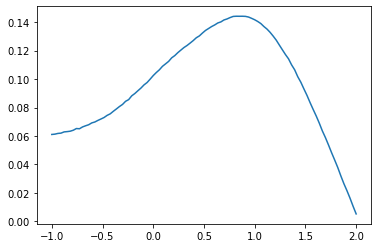

Epoch 7000 with loss 0.06356269121170044


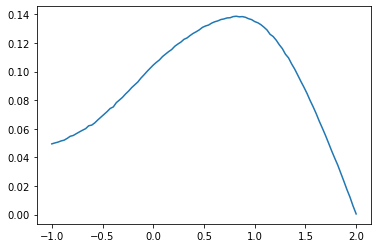

Epoch 7500 with loss 0.056263282895088196


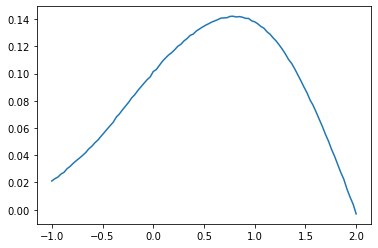

Epoch 8000 with loss 0.05006927251815796


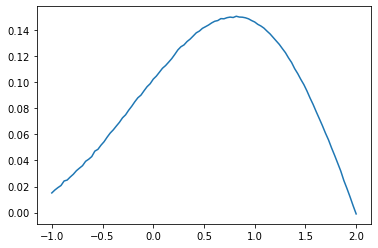

Epoch 8500 with loss 0.03991055488586426


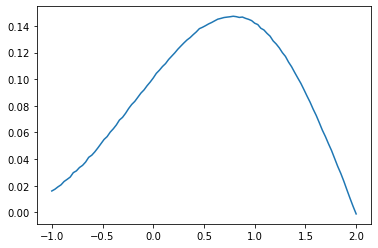

Epoch 9000 with loss 0.03220843896269798


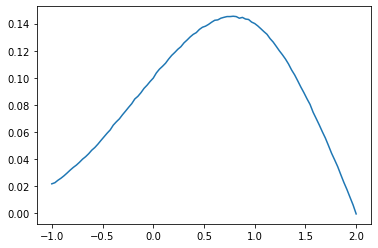

Epoch 9500 with loss 0.02545122057199478


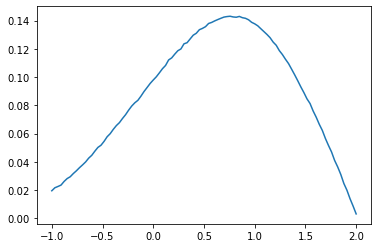

Epoch 9999 with loss 0.022177185863256454
Training of neural network with 10000 epochs take 148.87680578231812 seconds.


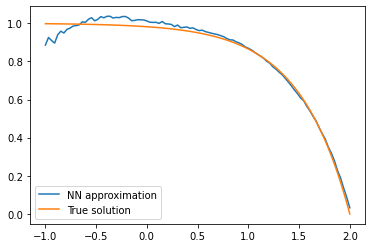

In [6]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
    overtrain_rate=0.,
    verbose=True,
    lambda_terminal=1.,
    lambda_boundary=10.,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
nn /= (norm.cdf(b - grid) - norm.cdf(a - grid))
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.legend()
plt.show()

In [7]:
tx, tx_term, tx_bound = model.gen_sample()

print(
    f"Terminal loss: {model.loss(model(tx_term.T), model.phi_fun(tx_term[1:, :])).item()}"
)
print(
    f"PDE loss: {model.pde_loss(tx)}"
)
print(
    f"Boundary loss: {model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1]))}"
)

Terminal loss: 0.019741717725992203
PDE loss: 0.0034045714419335127
Boundary loss: 1.012984193948796e-05
